# Business Problem:
A group of customers were given an offer in person that they can get a loan at discounted rate and
processing fee will be waived off. A pilot campaign was conducted to get response from customers
whether they are interested in taking out a loan or not. Response was recorded and data was collected.
Based on data given we need to

- [x] Build a model to predict whether customers will be interested in taking out a loan or not.
- [ ] Identifying features which are most important
- [ ] In case of black box models e.g. Random forest use SHAP, LIME to figure out features affecting the target variable
- [ ] Approaching a customer has costs involved with it, hence find the profitable segments so that more customized marketing can be done.
- [ ] Model will be needed on a monthly basis as this data gets updated each month.

Variables involved: `Customer_id`, `Age`, `Gender`, `Balance`, `Occupation`, `No of Credit transaction`, `SCR`, `Holding period`

> ## Questions for the External Mentor


- [ ] `Holding Period` (units of measurement months/years)
- [ ] `Balance` units of measurement and is it current balance/quarterly etc?
- [ ] `SCR` Solvency Capital Requirement explain in detail
- [ ] `No. of Credit Transactions` meaning?
- [ ] `O` in `Gender` columnn, does it mean null value?
- [ ] What do the values in `Occupation` stand for `SELF-EMP`, `SAL`, `SENP`, `PROF`?
- [ ] Need a summary of what is going on
- [ ] 

SCR propensity of a customer to respond to a digital marketing

##### Changes v6:
1. Now All Models measure recall on same testing data

2. Fixed Sampling mistake

3. Redefined `print_classification_report` as `classification_report` for better clarity and ease of use

4. Visualized Decision Trees

5. Implemented SVC

6. Implemented KNN which provided great results with default parameters

##### Changes v7:
1. Fit Random Forest Models

2. Fit XgBoost Models

##### Changes v9:
1. Added cross validation

2. Added ROC plots

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_curve, auc, plot_roc_curve
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

import xgboost as xgb

In [2]:
data = pd.read_csv('Model_data.csv')
data.head()

,Target,Age,Gender,Balance,Occupation,No_OF_CR_TXNS,SCR,Holding_Period
0,0,41,M,91519.92,SELF-EMP,38,926,15
1,0,52,M,117288.96,SAL,17,768,13
2,0,31,F,259827.44,SENP,8,816,5
3,0,45,F,26677.55,PROF,14,353,18
4,0,39,F,43440.31,SENP,1,751,31


In [3]:
data.Balance = data.Balance.astype('int32') #Truncating decimals

In [4]:
data[data.Balance<0]

,Target,Age,Gender,Balance,Occupation,No_OF_CR_TXNS,SCR,Holding_Period


In [5]:
data.head()

,Target,Age,Gender,Balance,Occupation,No_OF_CR_TXNS,SCR,Holding_Period
0,0,41,M,91519,SELF-EMP,38,926,15
1,0,52,M,117288,SAL,17,768,13
2,0,31,F,259827,SENP,8,816,5
3,0,45,F,26677,PROF,14,353,18
4,0,39,F,43440,SENP,1,751,31


In [6]:
data.Balance.describe()

count    2.000000e+04
mean     1.461808e+05
std      1.698125e+05
min      0.000000e+00
25%      2.373650e+04
50%      7.975550e+04
75%      2.173100e+05
max      1.246966e+06
Name: Balance, dtype: float64

In [7]:
data.shape

(20000, 8)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Target          20000 non-null  int64 
 1   Age             20000 non-null  int64 
 2   Gender          20000 non-null  object
 3   Balance         20000 non-null  int32 
 4   Occupation      20000 non-null  object
 5   No_OF_CR_TXNS   20000 non-null  int64 
 6   SCR             20000 non-null  int64 
 7   Holding_Period  20000 non-null  int64 
dtypes: int32(1), int64(5), object(2)
memory usage: 1.1+ MB


`Gender` and `Occupation` are categorical varibles stored as object type

**EDA**

No Strong correlations measured except for mild ones in `Holding_period` and other variables

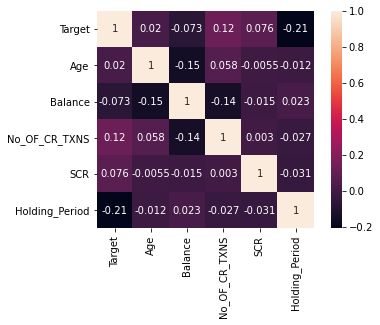

In [9]:
sns.heatmap(data.corr(), annot=True, square=True) # No strong correlations seen overall
plt.show()

In [10]:
# sns.pairplot(data)
# plt.show()

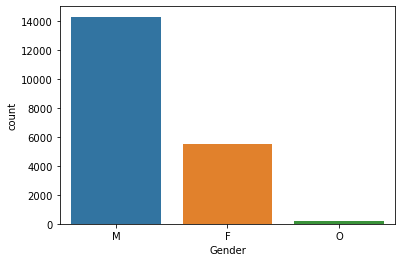

In [11]:
sns.countplot(x = data.Gender)
plt.show()

In [12]:
data.Gender.unique()

array(['M', 'F', 'O'], dtype=object)

In [13]:
data.Occupation.unique()

array(['SELF-EMP', 'SAL', 'SENP', 'PROF'], dtype=object)

In [14]:
data.Gender.value_counts()

M    14279
F     5525
O      196
Name: Gender, dtype: int64

In [15]:
data.drop(data.Gender[data.Gender== 'O'].index, axis = 0, inplace= True) # Removed 196 rows with `Gender` = 'O'

In [16]:
data.shape

(19804, 8)

In [17]:
data.Balance.describe()

count    1.980400e+04
mean     1.465609e+05
std      1.694485e+05
min      0.000000e+00
25%      2.399900e+04
50%      8.035100e+04
75%      2.183090e+05
max      1.246966e+06
Name: Balance, dtype: float64

In [18]:
# sns.histplot(data.Age)

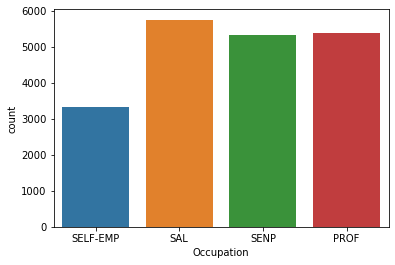

In [19]:
sns.countplot(x = data.Occupation)

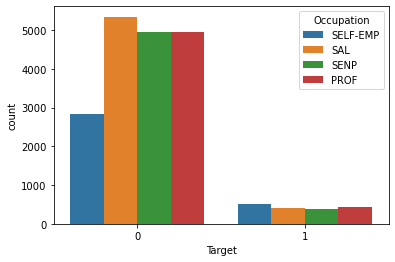

In [20]:
sns.countplot(x=data.Target, hue=data.Occupation) ## Self employed are much more likely to take loans

C:\Anaconda\lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


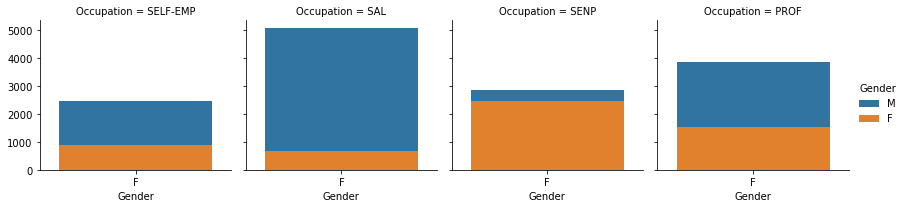

In [21]:
g = sns.FacetGrid(data, col='Occupation', hue="Gender")
plt.grid(True)
g.map(sns.countplot, "Gender", alpha=1)
g.add_legend()
plt.grid((False))

--------------------------

In [22]:
# sns.histplot(data.No_OF_CR_TXNS)

In [23]:
data.No_OF_CR_TXNS.describe()

count    19804.000000
mean        16.563169
std         12.928214
min          0.000000
25%          7.000000
50%         13.000000
75%         21.000000
max         50.000000
Name: No_OF_CR_TXNS, dtype: float64

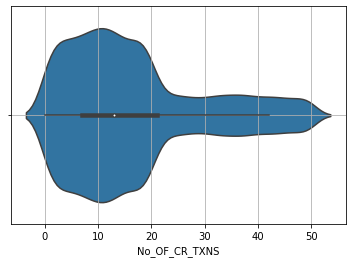

In [24]:
sns.violinplot(x=data.No_OF_CR_TXNS)
plt.grid(True)

In [25]:
# len(data[data.No_OF_CR_TXNS==0].index)

In [26]:
# data.drop(index=data[data.No_OF_CR_TXNS==0].index, axis=0)

------------------

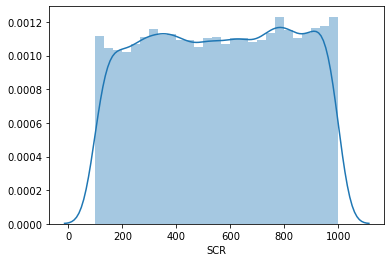

In [27]:
# sns.displot(data.SCR, kind = 'kde')
sns.distplot(data.SCR)
plt.show()

In [28]:
data.SCR.describe()

count    19804.000000
mean       557.115987
std        260.562729
min        100.000000
25%        332.000000
50%        560.500000
75%        784.250000
max        999.000000
Name: SCR, dtype: float64

In [29]:
# sns.histplot(data.Holding_Period)

##### End of Exploratory Data Analysis
-----------
----------

> ### Create a function for easy report printing

In [30]:
# A class for pretty printing
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    
# function for validation on test data   
def classification_report(y_true, y_prediction, type_of_data='Enter Over/Under/Original sampled', type_of_classifier='ClassifierName'):
    """Print Classification report"""
    
    accuracy = accuracy_score(y_true, y_prediction)
    precision = precision_score(y_true, y_prediction)
    recall = recall_score(y_true, y_prediction)
    f1 = f1_score(y_true, y_prediction)
    
    print('Classification Report on Testing Data:\n'+ color.BOLD + type_of_data, 'data\n'+color.END+color.RED+color.BOLD+type_of_classifier,'Classifier'+color.END+color.END)
    print()
    print('---------------------------------------')
    print(color.BOLD + 'Recall: %s' %recall + color.END)
    print('Precision: %s' %precision)
    print('F1 score: %s' %f1)
    print('Accuracy: %s' %accuracy)
    print('---------------------------------------')
    print()


# A function for cross-validation report    
def cross_val_report(classifier, train_data, train_label, cv=10, scoring=['recall','precision', 'f1','accuracy']):
    
    score = cross_validate(classifier, train_data, train_label, cv=cv, scoring= scoring)
    recall = np.mean(score['test_recall'])
    precision = np.mean(score['test_precision'])
    f1 = np.mean(score['test_f1'])
    accuracy= np.mean(score['test_accuracy'])
    print('Cross Validation Report')
    print(color.BOLD + 'Recall: %s' %recall + color.END)
    print('Precision: %s' %precision)
    print('F1: %s' %f1)
    print('Accuracy: %s' %accuracy)
    print()
    print("*Mean values presented")
    print('---------------------------------------')

**Create the first set of training and test data on imbalanced data**

In [31]:
df = pd.get_dummies(data, columns=['Gender','Occupation'], drop_first = True)
df.head()

,Target,Age,Balance,No_OF_CR_TXNS,SCR,Holding_Period,Gender_M,Occupation_SAL,Occupation_SELF-EMP,Occupation_SENP
0,0,41,91519,38,926,15,1,0,1,0
1,0,52,117288,17,768,13,1,1,0,0
2,0,31,259827,8,816,5,0,0,0,1
3,0,45,26677,14,353,18,0,0,0,0
4,0,39,43440,1,751,31,0,0,0,1


>**Creating a model with Original Unbalanced data and measuring metrics**

In [32]:
X_original = df.iloc[:,1:]
y_original = df.iloc[:,0]

In [33]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_original,y_original, shuffle = ['True'], stratify=y_original)

Classification Report on Testing Data:
Original data
Decision Tree Classifier

---------------------------------------
Recall: 0.12412177985948478
Precision: 0.6625
F1 score: 0.20907297830374755
Accuracy: 0.9190062613613411
---------------------------------------



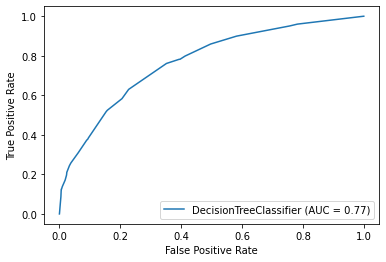

In [34]:
clf = DecisionTreeClassifier(max_depth = 5)
clf.fit(X_train_orig, y_train_orig)
y_prediction_orig = clf.predict(X_test_orig)
classification_report(y_test_orig, y_prediction_orig, 'Original', 'Decision Tree')
plot_roc_curve(clf, X_test_orig, y_test_orig)
plt.show()
# cross_val_report(clf, y_test_orig,y_under_prediction.reshape(1,-1))

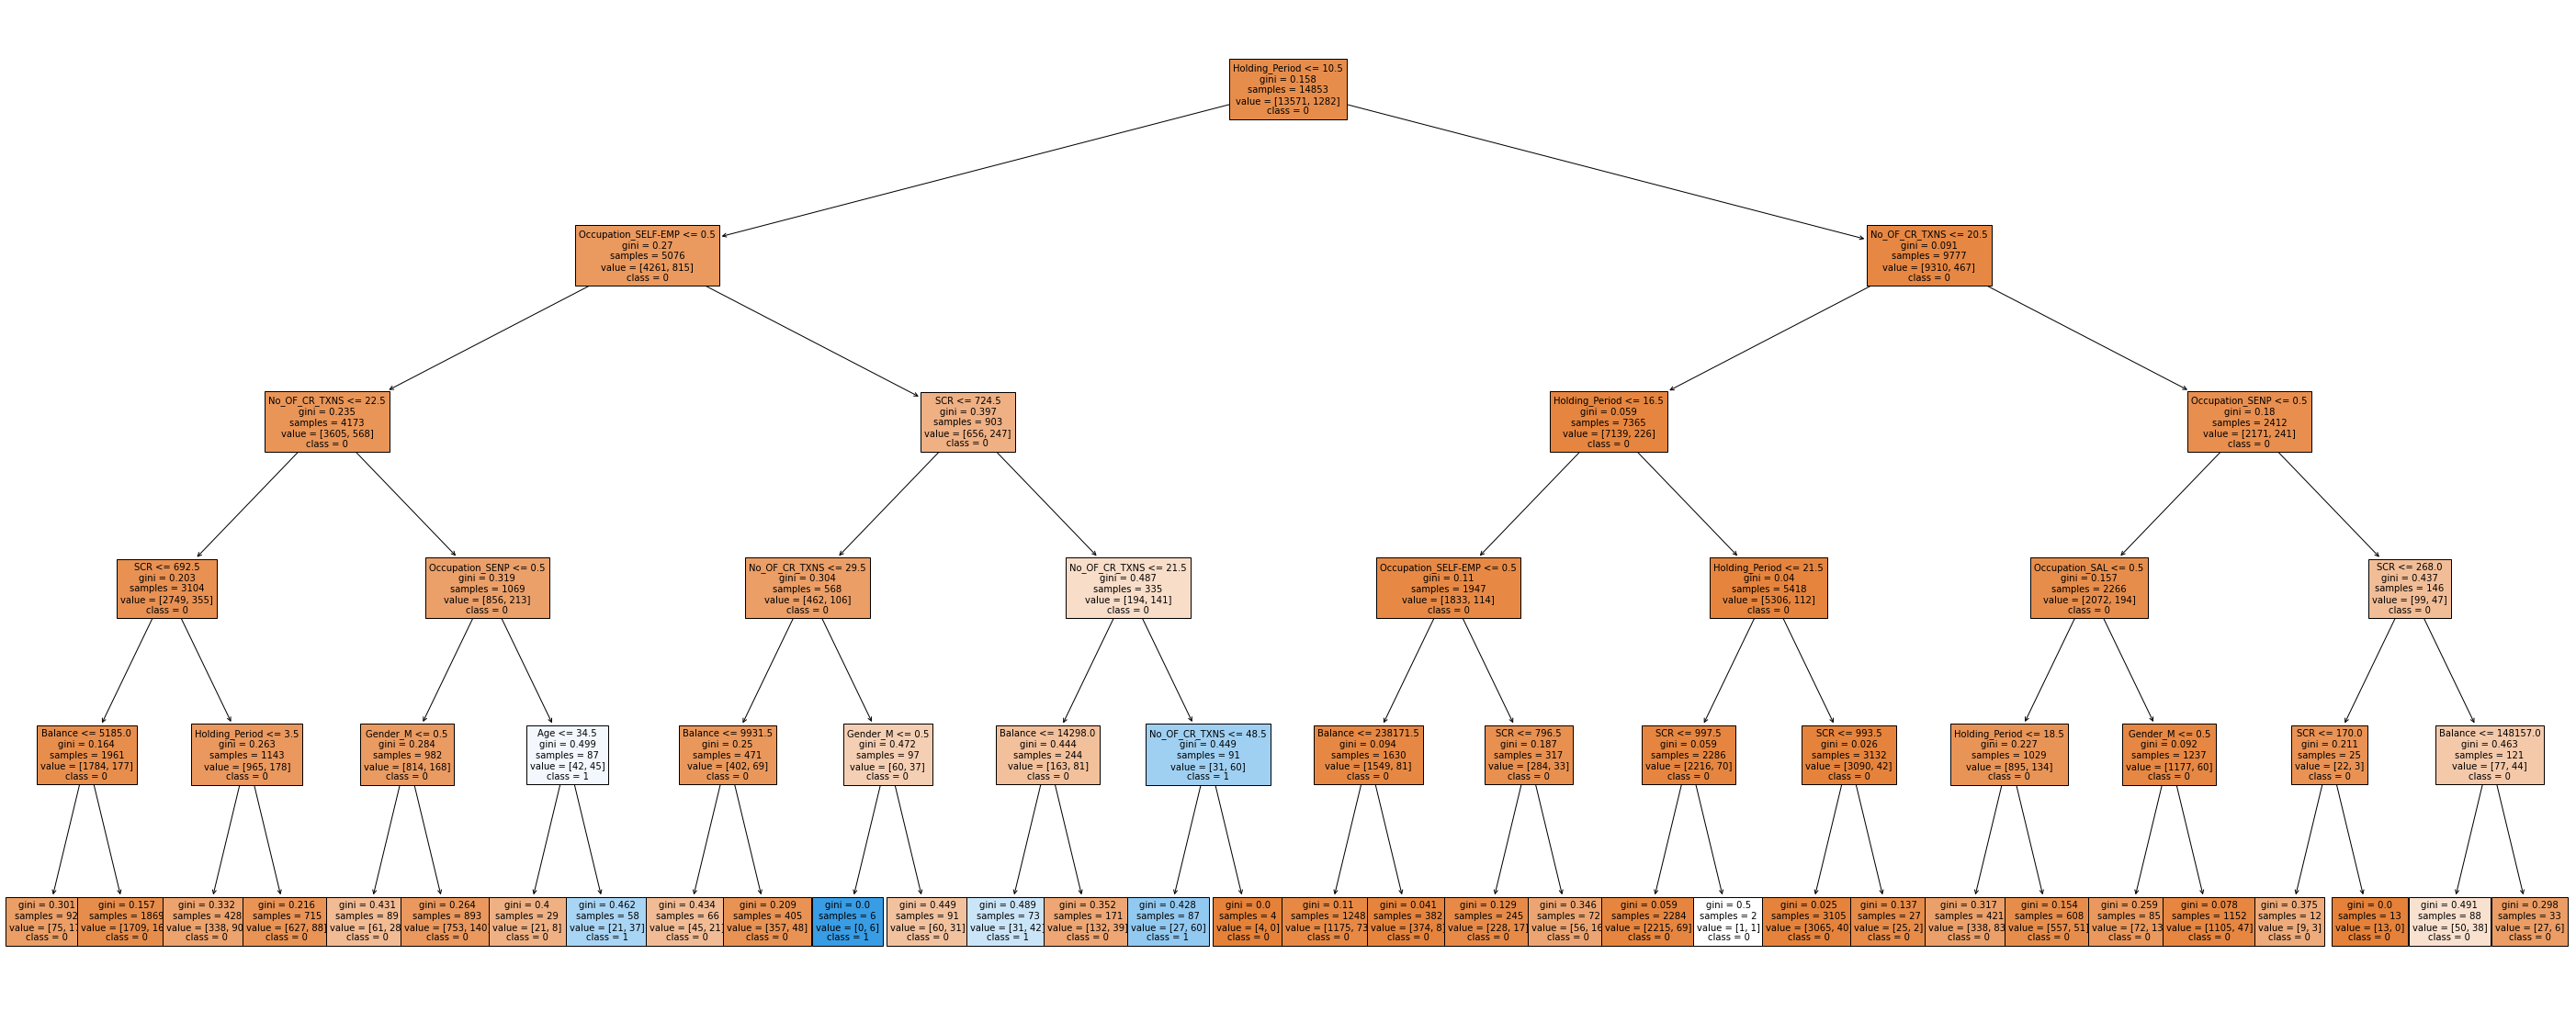

In [35]:
fig = plt.figure(figsize=(50,20))
_ = plot_tree(clf, 
                   feature_names=list(X_original.columns),  
                   class_names=['0','1'],
                   filled=True, fontsize=10)

-----------

>**Create undersampled data and fit a model**

In [36]:
X_under_train, y_under_train = NearMiss().fit_resample(X_train_orig, y_train_orig)

In [37]:
data[data.Target==1].shape

(1709, 8)

In [38]:
X_under_train.shape, y_under_train.shape

((2564, 9), (2564,))

Classification Report on Testing Data:
Undersampled data
Decision Tree Classifier

---------------------------------------
Recall: 0.7634660421545667
Precision: 0.09088374686367438
F1 score: 0.16243148978574987
Accuracy: 0.32094526358311454
---------------------------------------



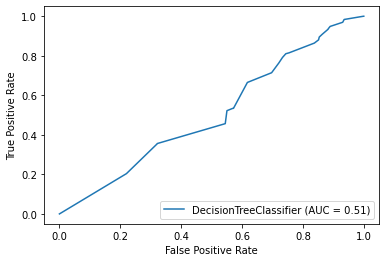

In [39]:
clf_under_sampled = DecisionTreeClassifier(max_depth = 5)
clf_under_sampled.fit(X_under_train, y_under_train)
y_under_prediction = clf_under_sampled.predict(X_test_orig)
classification_report(y_test_orig,y_under_prediction, 'Undersampled', 'Decision Tree')
plot_roc_curve(clf_under_sampled, X_test_orig, y_test_orig)

In [40]:
# cross_val_report(clf_under_sampled, y_test_orig,y_under_prediction)

## crossval here causes unbalanced split

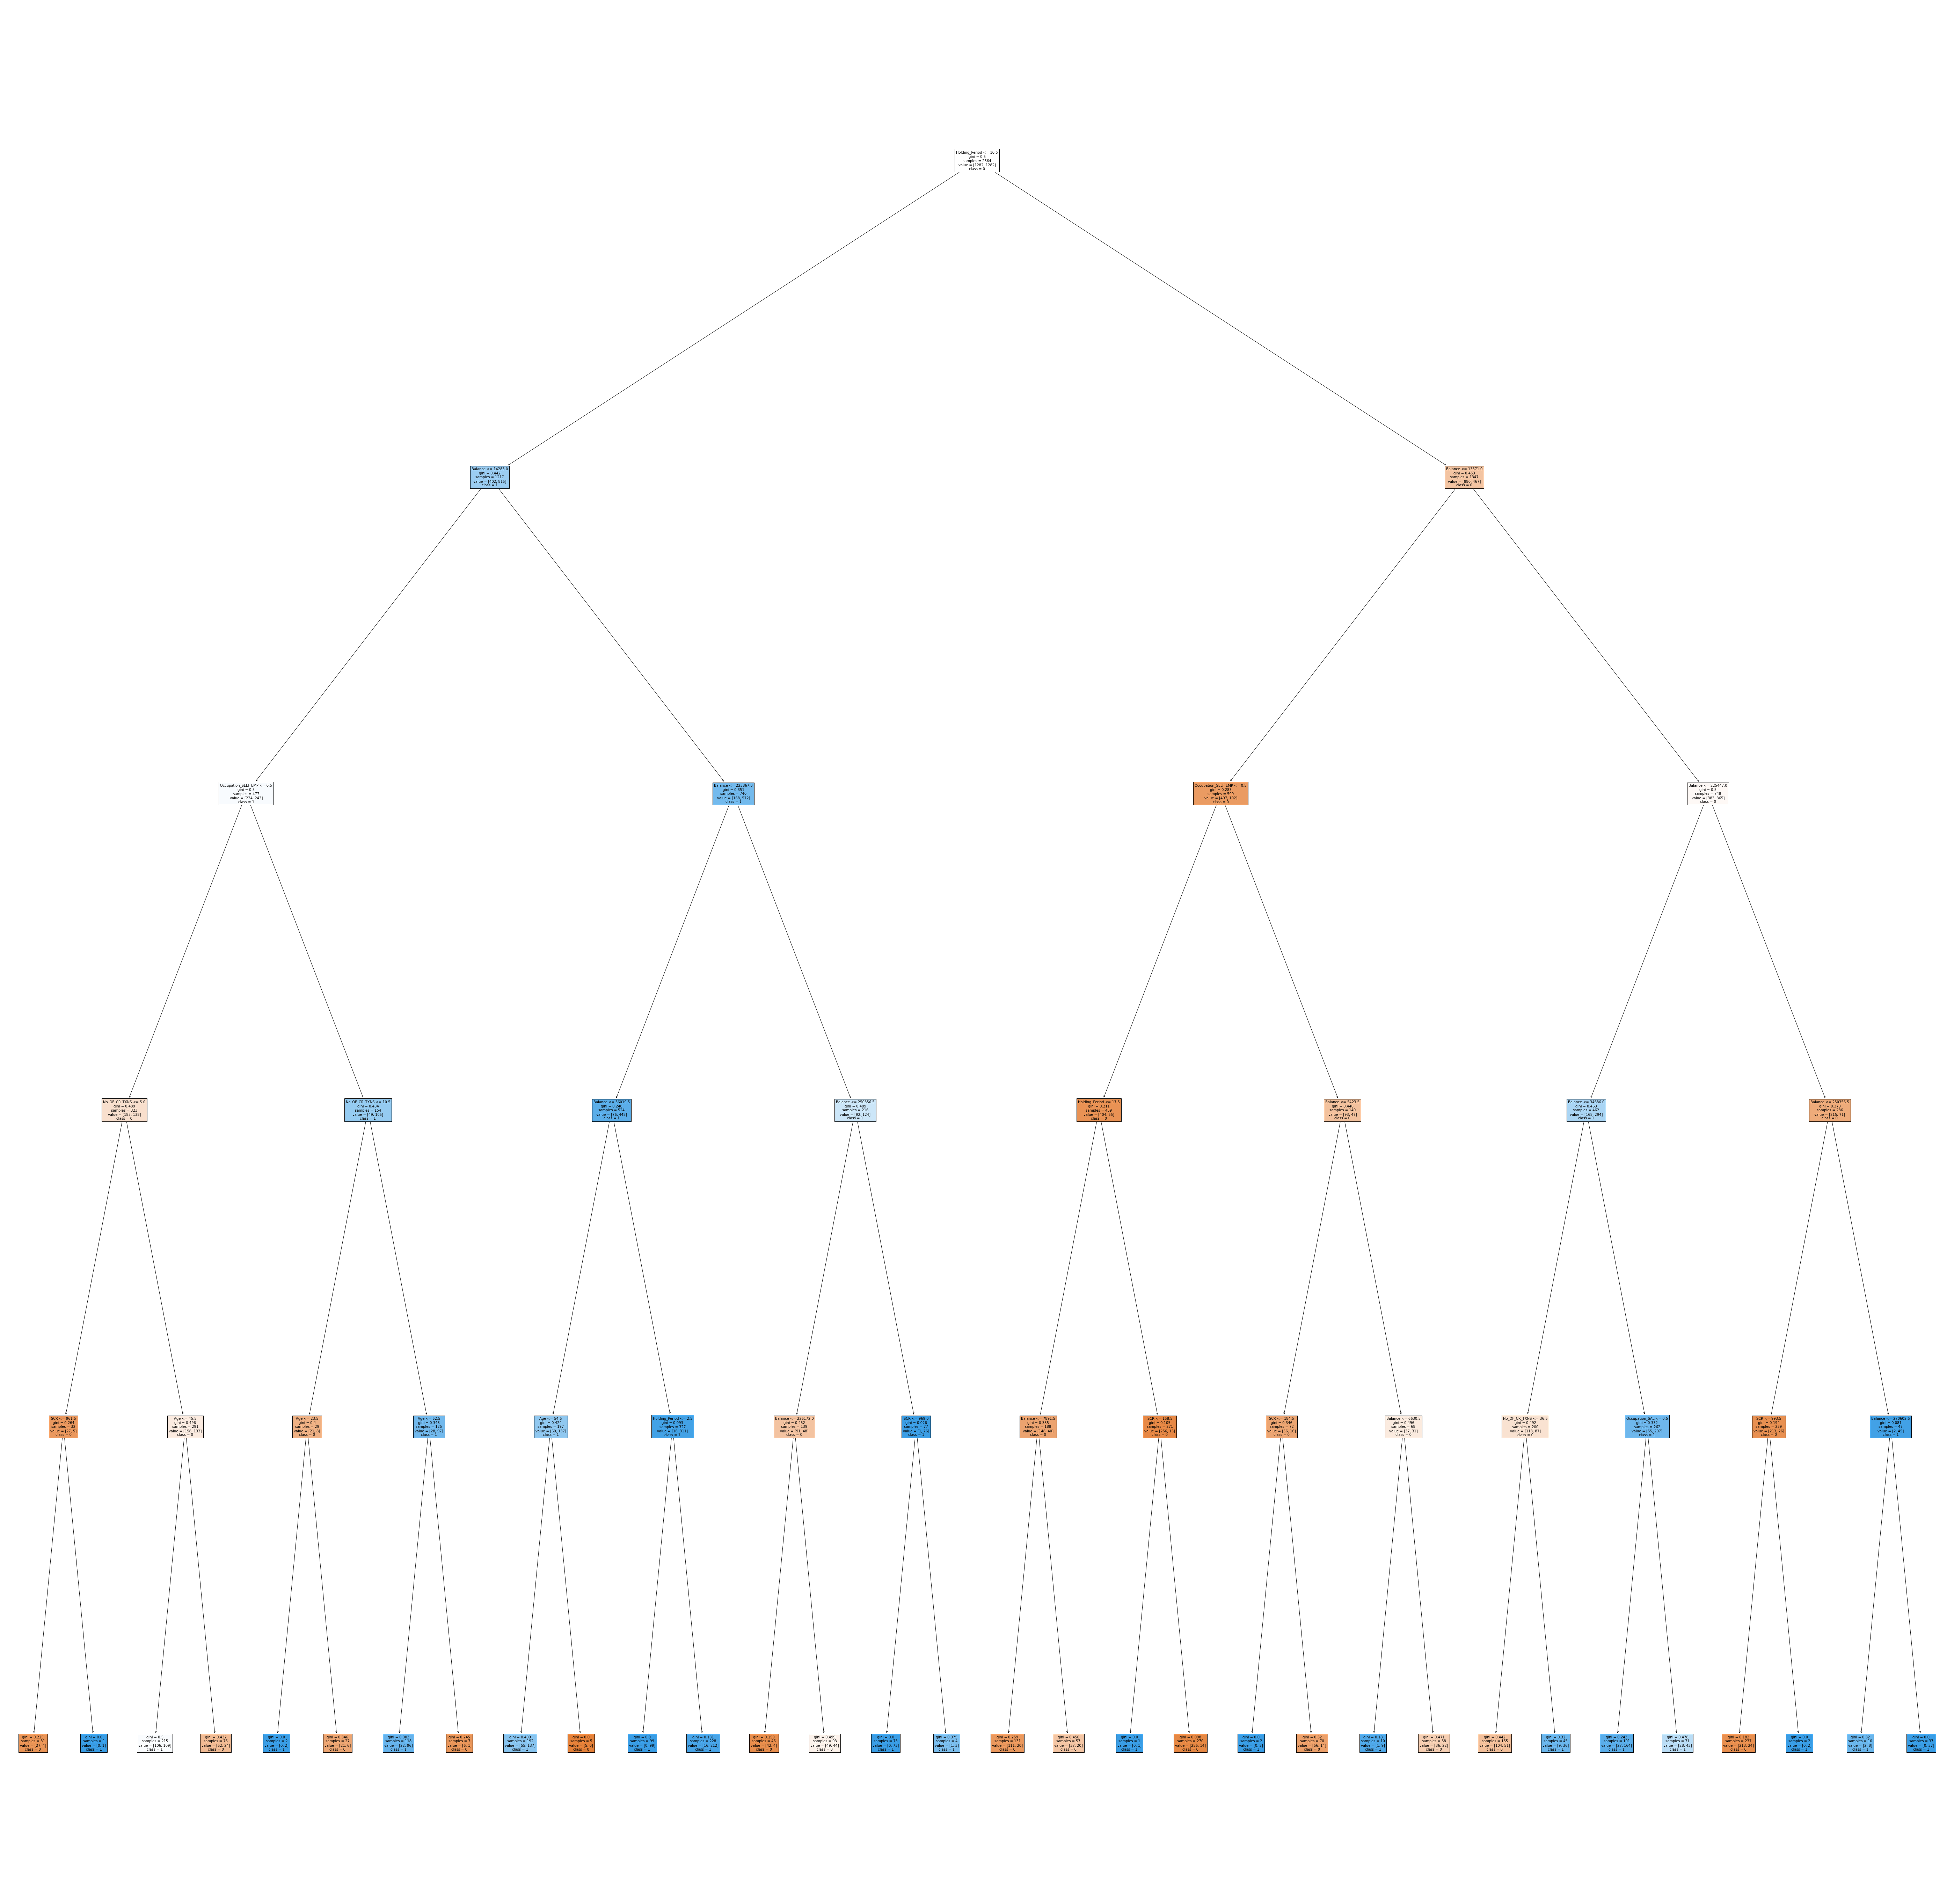

In [41]:
fig = plt.figure(figsize=(100,100))
_ = plot_tree(clf_under_sampled, 
                   feature_names=list(X_original.columns),  
                   class_names=['0','1'],
                   filled=True, fontsize=10)

--------------------

> Model on  an oversampled dataset

In [42]:
X_over_train, y_over_train = SMOTE().fit_resample(X_original, y_original)

Classification Report on Testing Data:
Oversampled data
Decision Tree Classifier

---------------------------------------
Recall: 0.6135831381733021
Precision: 0.18006872852233677
F1 score: 0.2784272051009564
Accuracy: 0.7257119773783074
---------------------------------------



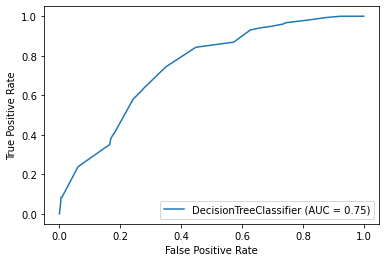

In [43]:
clf_over_sampled = DecisionTreeClassifier(max_depth = 5)
clf_over_sampled.fit(X_over_train, y_over_train)
y_over_predict = clf_over_sampled.predict(X_test_orig)
classification_report(y_test_orig, y_over_predict, 'Oversampled', 'Decision Tree')
plot_roc_curve(clf_over_sampled, X_test_orig, y_test_orig)

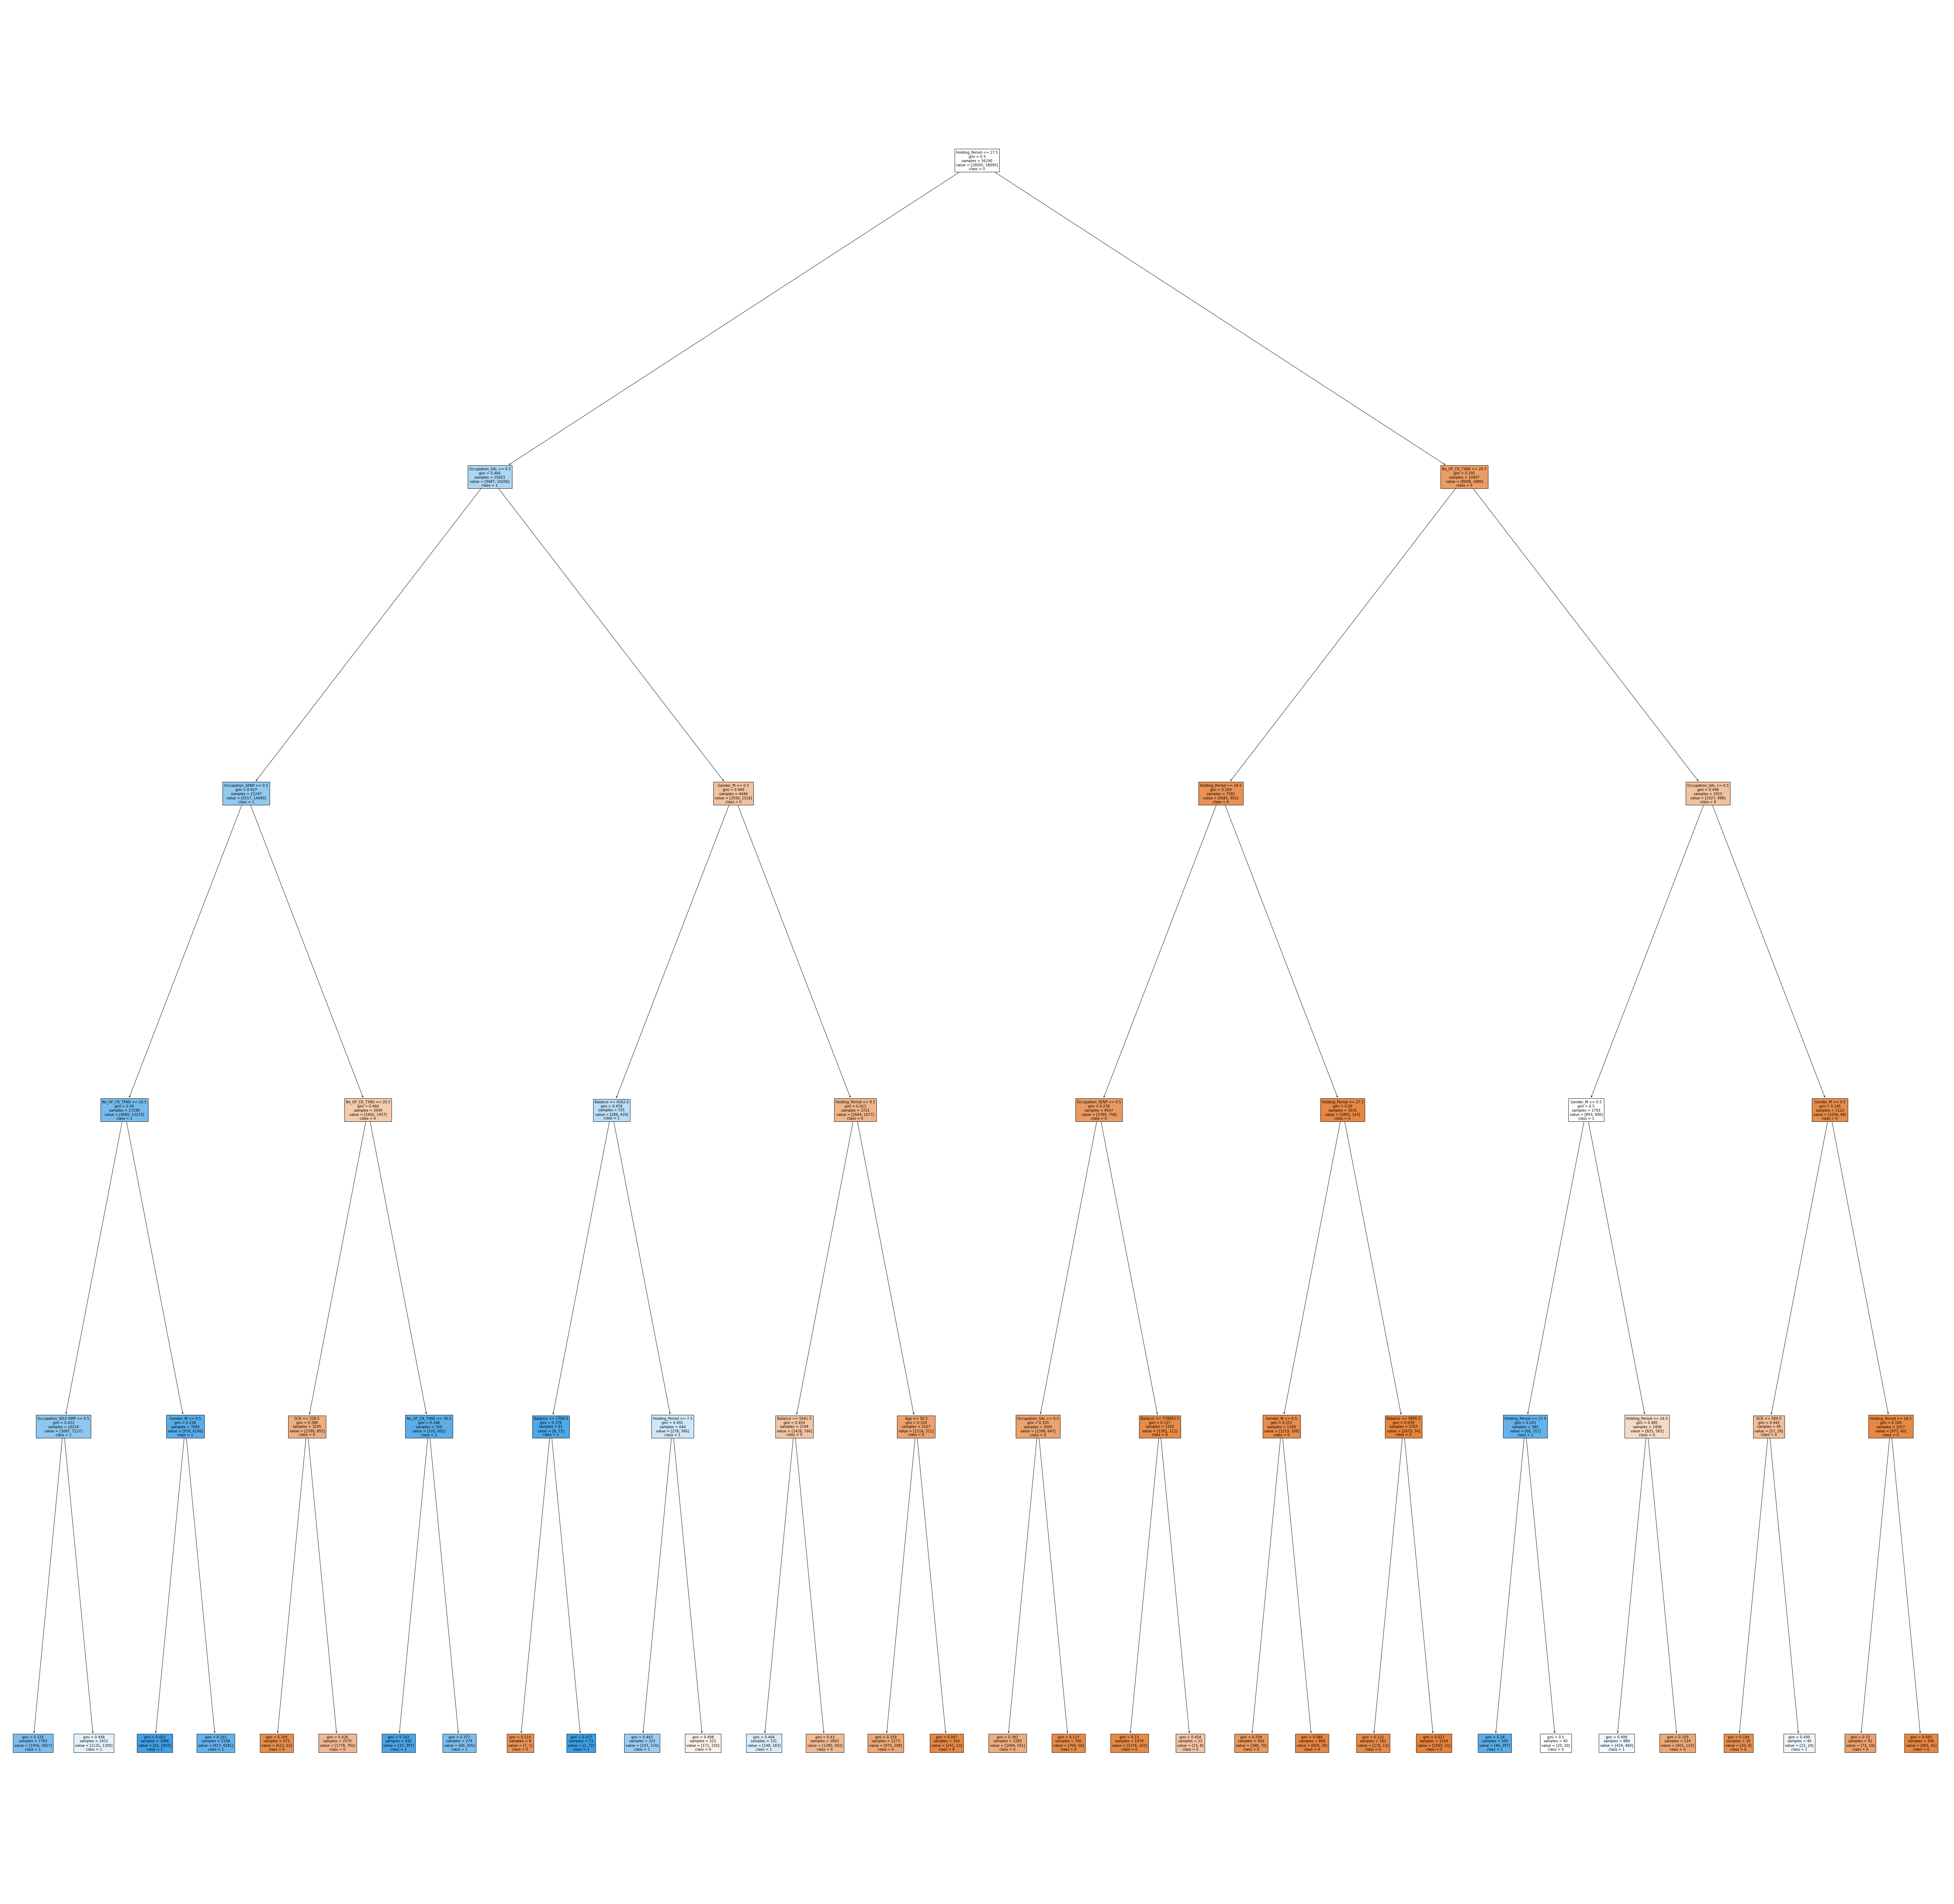

In [44]:
fig = plt.figure(figsize=(100,100))
_ = plot_tree(clf_over_sampled, 
                   feature_names=list(X_original.columns),  
                   class_names=['0','1'],
                   filled=True, fontsize=10)

---------------

In [45]:
print("Original:     "+color.BOLD+ "X_original,y_original"+color.END+"::  X_train_orig, X_test_orig, y_train_orig, y_test_orig")
print()
print("Undersampled:"+color.BOLD+ " X_under, y_under"+color.END+"     ::  X_under_train, y_under_train")
print()
print("Oversampled:"+color.BOLD+ "  X_over, y_over"+color.END+"       ::  X_over_train, y_over_train")

Original:     X_original,y_original::  X_train_orig, X_test_orig, y_train_orig, y_test_orig

Undersampled: X_under, y_under     ::  X_under_train, y_under_train

Oversampled:  X_over, y_over       ::  X_over_train, y_over_train


The above datasets can be better sampled by adjusting hyper-parameters of NearMiss and SMOTE, or other methods of sampling could be used

-----------
-----------

### SVM Classifiers applied

*SVC fails to fit on original dataset, possibly because of unbalance*

Classification Report on Testing Data:
Undersampled data
SVM Classifier

---------------------------------------
Recall: 0.5152224824355972
Precision: 0.07248764415156507
F1 score: 0.1270941652224148
Accuracy: 0.3896182589375884
---------------------------------------

Cross Validation Report
Recall: 0.5102107558139535
Precision: 0.8411434064286654
F1: 0.6325596921567984
Accuracy: 0.7047680569066148

*Mean values presented
---------------------------------------


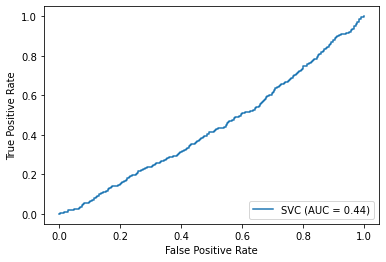

In [46]:
clf_svc0 = SVC()
clf_svc0.fit(X_under_train, y_under_train)
y_predict = clf_svc0.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Undersampled', 'SVM')
plot_roc_curve(clf_svc0, X_test_orig, y_test_orig)
cross_val_report(clf_svc0, X_under_train, y_under_train)

In [47]:
# %%time
# # Will take LONG Time for Training
# clf_svc1 = SVC()
# clf_svc1.fit(X_over_train, y_over_train)
# y_predict = clf_svc1.predict(X_test_orig)
# classification_report(y_test_orig, y_predict, 'Oversampled', 'SVM')
# plot_roc_curve(clf_svc1, X_test_orig, y_test_orig)
# cross_val_report(clf_svc1, X_under_train, y_under_train)

-------------
--------------------

Classification Report on Testing Data:
Original data
KNN Classifier

---------------------------------------
Recall: 0.06557377049180328
Precision: 0.30434782608695654
F1 score: 0.10789980732177264
Accuracy: 0.9064835386790547
---------------------------------------

Cross Validation Report
Recall: 0.6107982073643411
Precision: 0.7341965775864703
F1: 0.6649755253034496
Accuracy: 0.6899729450389105

*Mean values presented
---------------------------------------


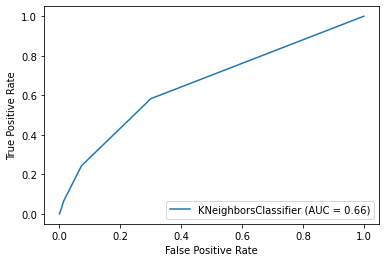

In [48]:
clf_KNN0 = KNeighborsClassifier()
clf_KNN0.fit(X_train_orig, y_train_orig)
y_predict= clf_KNN0.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Original', 'KNN')
plot_roc_curve(clf_KNN0, X_test_orig, y_test_orig)
cross_val_report(clf_KNN0, X_under_train, y_under_train)

-----------

Classification Report on Testing Data:
Undersampled data
KNN Classifier

---------------------------------------
Recall: 0.7494145199063232
Precision: 0.08152866242038216
F1 score: 0.14705882352941174
Accuracy: 0.25025247424762675
---------------------------------------

Cross Validation Report
Recall: 0.6107982073643411
Precision: 0.7341965775864703
F1: 0.6649755253034496
Accuracy: 0.6899729450389105

*Mean values presented
---------------------------------------


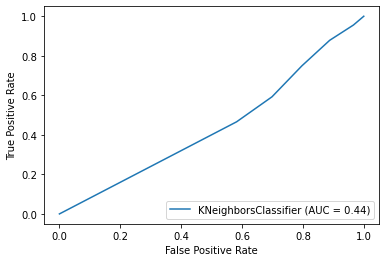

In [49]:
clf_KNN1 = KNeighborsClassifier()
clf_KNN1.fit(X_under_train, y_under_train)
y_predict= clf_KNN1.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Undersampled', 'KNN')
plot_roc_curve(clf_KNN1, X_test_orig, y_test_orig)
cross_val_report(clf_KNN1, X_under_train, y_under_train)

--------------

Classification Report on Testing Data:
Oversampled data
KNN Classifier

---------------------------------------
Recall: 0.9203747072599532
Precision: 0.33418367346938777
F1 score: 0.4903306300686213
Accuracy: 0.8349828317511614
---------------------------------------

Cross Validation Report
Recall: 0.6107982073643411
Precision: 0.7341965775864703
F1: 0.6649755253034496
Accuracy: 0.6899729450389105

*Mean values presented
---------------------------------------


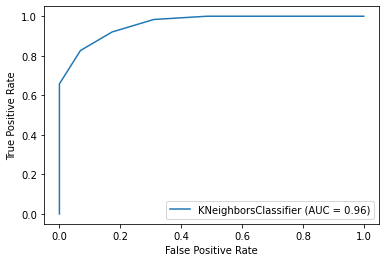

In [50]:
clf_KNN2 = KNeighborsClassifier()
clf_KNN2.fit(X_over_train, y_over_train)
y_predict= clf_KNN2.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Oversampled', 'KNN')
plot_roc_curve(clf_KNN2, X_test_orig, y_test_orig)
cross_val_report(clf_KNN2, X_under_train, y_under_train)

----------
----------

### Random Forest Classifier Models

Classification Report on Testing Data:
Original data
Random Forest Classifier

---------------------------------------
Recall: 0.13817330210772832
Precision: 0.6781609195402298
F1 score: 0.22957198443579765
Accuracy: 0.9200161583518481
---------------------------------------

Cross Validation Report
Recall: 0.8026344476744185
Precision: 0.7894947875830972
F1: 0.7953493066662357
Accuracy: 0.7932864178015564

*Mean values presented
---------------------------------------


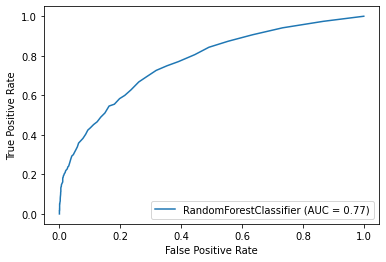

In [51]:
clf_rf0 = RandomForestClassifier()
clf_rf0.fit(X_train_orig, y_train_orig)
y_predict= clf_rf0.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Original', 'Random Forest')
plot_roc_curve(clf_rf0, X_test_orig, y_test_orig)
cross_val_report(clf_rf0, X_under_train, y_under_train)

-------------

Classification Report on Testing Data:
Undersampled data
Random Forest Classifier

---------------------------------------
Recall: 0.8313817330210773
Precision: 0.10389230318993269
F1 score: 0.18470343392299687
Accuracy: 0.36699656635023226
---------------------------------------

Cross Validation Report
Recall: 0.8010780038759691
Precision: 0.7955213290264592
F1: 0.7974187549890587
Accuracy: 0.796390138618677

*Mean values presented
---------------------------------------


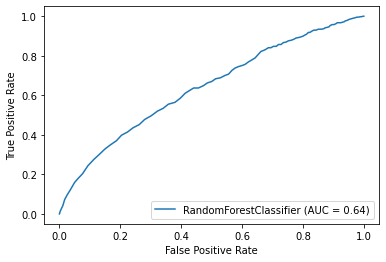

In [52]:
clf_rf1 = RandomForestClassifier()
clf_rf1.fit(X_under_train, y_under_train)
y_predict= clf_rf1.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Undersampled', 'Random Forest')
plot_roc_curve(clf_rf1, X_test_orig, y_test_orig)
cross_val_report(clf_rf1, X_under_train, y_under_train)

-------------

In [53]:
clf_rf2 = RandomForestClassifier()

Classification Report on Testing Data:
Oversampled data
Random Forest Classifier

---------------------------------------
Recall: 0.8290398126463701
Precision: 0.10314685314685315
F1 score: 0.18346721948691372
Accuracy: 0.3635629165825086
---------------------------------------

Cross Validation Report
Recall: 0.7963844476744186
Precision: 0.7944152698776455
F1: 0.7948835299698208
Accuracy: 0.794052468385214

*Mean values presented
---------------------------------------


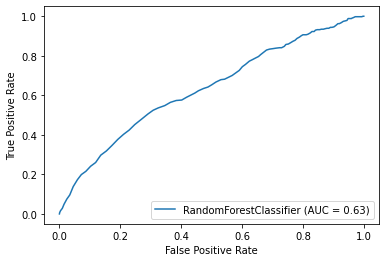

In [54]:
clf_rf2.fit(X_under_train, y_under_train)
y_predict= clf_rf2.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Oversampled', 'Random Forest')
plot_roc_curve(clf_rf2, X_test_orig, y_test_orig)
cross_val_report(clf_rf2, X_under_train, y_under_train)

----------
----------------

# Xgboost Models

### Changing training and testing data to DMatrix types

In [55]:
train_orig_DM = xgb.DMatrix(X_train_orig, label= y_train_orig)
train_under_DM = xgb.DMatrix(X_under_train, label= y_under_train)
train_over_DM = xgb.DMatrix(X_over_train, label= y_over_train)

test_DM = xgb.DMatrix(X_test_orig, label= y_test_orig)

In [56]:
param = {
    'max_depth': 5,
    'eta': 0.1,
    'objective': 'multi:softmax',
    'num_class': 3
}

epochs = 10

In [57]:
xgb_cl0 = xgb.train(param, train_orig_DM, epochs)
predictions = xgb_cl0.predict(test_DM)
classification_report(y_test_orig, predictions, 'Original', 'XgBoost')

Classification Report on Testing Data:
Original data
XgBoost Classifier

---------------------------------------
Recall: 0.06791569086651054
Precision: 0.6904761904761905
F1 score: 0.1236673773987207
Accuracy: 0.9169864673803272
---------------------------------------



In [58]:
xgb_cl1 = xgb.train(param, train_under_DM, epochs)
predictions = xgb_cl1.predict(test_DM)
classification_report(y_test_orig, predictions, 'Undersampled', 'XgBoost')

Classification Report on Testing Data:
Undersampled data
XgBoost Classifier

---------------------------------------
Recall: 0.7915690866510539
Precision: 0.09462486002239642
F1 score: 0.1690422605651413
Accuracy: 0.32882246010906885
---------------------------------------



In [59]:
xgb_cl2 = xgb.train(param, train_over_DM, epochs)
predictions = xgb_cl2.predict(test_DM)
classification_report(y_test_orig, predictions, 'Oversampled', 'XgBoost')

Classification Report on Testing Data:
Oversampled data
XgBoost Classifier

---------------------------------------
Recall: 0.5831381733021077
Precision: 0.19227799227799228
F1 score: 0.289198606271777
Accuracy: 0.7527772167238942
---------------------------------------



-------
-------